# Hito 2 - Rendimiento Escolar
### Sebastián Contreras, Alejandro Vera.
### 8 de junio, 2022

## Contenidos
* [Introducción](#Introducción)
* [Exploración de datos](#Exploración-de-datos)
* [Preguntas y problemas](#Preguntas-y-problemas)
* [Propuesta experimental](#Propuesta-experimental)
* [Experimento preliminar](#Experimento-preliminar)
* [Repositorio](#Repositorio)
* [Trabajo realizado](#Trabajo-realizado)
* [Anexo A](#Anexo-A)

## Introducción

La educación es uno de los pilares de toda sociedad, y por lo tanto tener medidas para evaluar sus resultados y proponer medidas para mejorar es de vital importancia. En Chile, el Ministerio de Educación, a través de su Centro de Estudios, mantiene una plataforma de datos abiertos con una importante cantidad de información relativa a estudiantes, docentes y establecimientos, en un esfuerzo por transparentar los resultados de la importante labor a su cargo.

En este trabajo en particular, nos centraremos en los resultados académicos obtenidos por estudiantes de enseñanza básica y media durante el año escolar 2021, con la intención de encontrar regularidades y patrones que sean de interés para los propios estudiantes y el país en general.

Dada la granularidad de los datos, es posible segregar la información por comunas o regiones, género de los estudiantes, tipos de establecimientos y ruralidad, entre otras variables, que esperamos puedan combinarse de manera interesante y útil para la toma de decisiones futuras.

Este hito en particular se conforma por una mejora al hito anterior, en cuanto a la exploración sobre los datos y las preguntas realizadas, y por una propuesta experimental inicial que permita responder estas preguntas mejoradas.

## Exploración de datos

Para la exploración se utilizó la colección de datos de rendimiento académico por estudiante del año 2021. Esta colección contiene datos de 3.237.043 estudiantes de todos los niveles de enseñanza básica y media en el país.


In [13]:
#Se ejecuta para poder cargar código de R que teníamos anteriormente.
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [14]:
%%R 
rendimiento2021 <- read.csv2("https://gitlab.com/scontreras09/cphmr-datos/-/raw/main/csv/20220302_Rendimiento_2021_20220131_WEB.csv")

La descarga incluye un archivo que detalla las variables presentes en los datos, entre las que destacan:

-   `PROM_GRAL`: Promedio general anual del estudiante.

-   `ASISTENCIA`: Porcentaje anual de asistencia del estudiante.

-   `COD_REG_RBD` y `NOM_REG_RBD_A`: Código y nombre abreviado de la región en que se ubica el establecimiento.

-   `COD_DEPE2`: Código (agrupado) de dependencia administrativa del establecimiento (municipal, particular pagado, etc.).

-   `RURAL_RBD`: Índice de ruralidad del establecimiento.

La descarga contiene también otro archivo con estadísticas que relacionan los promedios generales y la asistencia con la dependencia administrativa. Por ello, nuestra exploración evitará estas relaciones.

En primera instancia, requerimos limpiar los datos, para lo cual nos valemos de la variable `SIT_FIN_R` que detalla el estado de aprobación del estudiante, esto porque algunos de los estudiantes que no presentan alguno de los estados "Promovido" o "Reprobado" aparecen con promedio general 0. Así, para evitar estos casos se considerarán solo aquellos estudiantes con estado "Promovido" o "Reprobado".

In [15]:
%%R
rend2021PromRep <- rendimiento2021[rendimiento2021$SIT_FIN_R == "P" | rendimiento2021$SIT_FIN_R == "R",]

Tambien revisamos cuales columnas del dataset tienen valores `NA`.

In [16]:
%%R
sapply(rend2021PromRep, function(x) sum(is.na(x)))

          AGNO            RBD        DGV_RBD        NOM_RBD    COD_REG_RBD 
             0              0              0              0              0 
 NOM_REG_RBD_A    COD_PRO_RBD    COD_COM_RBD    NOM_COM_RBD COD_DEPROV_RBD 
             0              0              0              0              0 
NOM_DEPROV_RBD       COD_DEPE      COD_DEPE2      RURAL_RBD   ESTADO_ESTAB 
             0              0              0              0              0 
      COD_ENSE      COD_ENSE2      COD_GRADO        LET_CUR        COD_JOR 
             0              0              0              0              0 
   COD_TIP_CUR    COD_DES_CUR           MRUN        GEN_ALU    FEC_NAC_ALU 
             0              0              0              0              0 
      EDAD_ALU    COD_REG_ALU    COD_COM_ALU    NOM_COM_ALU       COD_RAMA 
           143              0              0              0              0 
       COD_SEC       COD_ESPE      PROM_GRAL     ASISTENCIA        SIT_FIN 
            

Como se puede observar la columna `EDAD_ALU` es la única que tiene valores `NA`. Al ser un número muy bajo de ocurrencias, decidimos eliminar las filas con valores `NA`. Además, exportamos el dataframe a Pandas para posteriormente trabajar con el con librerías de Python

In [17]:
%%R -o rend2021PromRep
rend2021PromRep <- rend2021PromRep[!is.na(rend2021PromRep$EDAD_ALU),]
sapply(rend2021PromRep, function(x) sum(is.na(x)))

          AGNO            RBD        DGV_RBD        NOM_RBD    COD_REG_RBD 
             0              0              0              0              0 
 NOM_REG_RBD_A    COD_PRO_RBD    COD_COM_RBD    NOM_COM_RBD COD_DEPROV_RBD 
             0              0              0              0              0 
NOM_DEPROV_RBD       COD_DEPE      COD_DEPE2      RURAL_RBD   ESTADO_ESTAB 
             0              0              0              0              0 
      COD_ENSE      COD_ENSE2      COD_GRADO        LET_CUR        COD_JOR 
             0              0              0              0              0 
   COD_TIP_CUR    COD_DES_CUR           MRUN        GEN_ALU    FEC_NAC_ALU 
             0              0              0              0              0 
      EDAD_ALU    COD_REG_ALU    COD_COM_ALU    NOM_COM_ALU       COD_RAMA 
             0              0              0              0              0 
       COD_SEC       COD_ESPE      PROM_GRAL     ASISTENCIA        SIT_FIN 
            

Como podemos ver, ahora no hay ninguna fila con valores `NA`.

Aplicamos un _summary_ para evaluar las medidas de tendencia central. Cabe destacar que solo cuatro de las variables admiten un análisis de este tipo, tres de ellas ordinales y una binaria.

In [18]:
%%R
summary(rend2021PromRep[c("PROM_GRAL","ASISTENCIA","EDAD_ALU","RURAL_RBD")])

   PROM_GRAL       ASISTENCIA        EDAD_ALU       RURAL_RBD      
 Min.   :1.000   Min.   :  0.00   Min.   : 2.00   Min.   :0.00000  
 1st Qu.:5.500   1st Qu.: 85.00   1st Qu.: 9.00   1st Qu.:0.00000  
 Median :6.100   Median : 91.00   Median :12.00   Median :0.00000  
 Mean   :5.973   Mean   : 88.53   Mean   :12.44   Mean   :0.07789  
 3rd Qu.:6.600   3rd Qu.: 99.00   3rd Qu.:15.00   3rd Qu.:0.00000  
 Max.   :7.000   Max.   :100.00   Max.   :89.00   Max.   :1.00000  


Aplicamos _lapply_ para obtener la media y desviación estandar de una manera más ordenada y rapido en comparación al _summary_.

In [19]:
%%R
cbind(lapply(rend2021PromRep[c("PROM_GRAL","ASISTENCIA","EDAD_ALU","RURAL_RBD")], mean), lapply(rend2021PromRep[c("PROM_GRAL","ASISTENCIA","EDAD_ALU","RURAL_RBD")], sd))

           [,1]       [,2]     
PROM_GRAL  5.97255    0.8268459
ASISTENCIA 88.52749   16.4602  
EDAD_ALU   12.43716   5.445529 
RURAL_RBD  0.07789445 0.2680055


Hacemos un análisis de los establecimientos del dataset analizando las siguientes variables (las cuales son caracteristicas de los establecimientos):
 
 -   `ESTADO_ESTAB`: Estado en que se encuentra el establecimiento: 1:Funcionando, 2:En receso, 3:Cerrado, 4:Autorizado sin matricula.
 
 -   `COD_DEPE2`: Codigo dependencia del establecimiento (agrupado): 1:Municipal, 2:Particular Subvencionado, 3:Particular Pagado, 4: Coorporación de Administración Delegada, 5:Servicio Local de Educación.
 
 -   `RURAL_RBD`: Índice de ruralidad del establecimiento: 0:Urbano, 1:Rural.
 
 -   `COD_JOR`: Jornada en la que se asiste a clases. 1: Mañana, 2: Tarde, 3: Mañana y tarde,    4: Vespertina/Nocturna.

In [20]:
%%R
table(rend2021PromRep$ESTADO_ESTAB) #Todos los establecimientos estan funcionando.


      1 
3091645 


Lo primero que podemos observar es que el 100% de los establecimientos del dataset estan funcionando.

In [21]:
%%R
prop.table(table(rend2021PromRep$COD_DEPE2))


         1          2          3          4          5 
0.32082338 0.52449457 0.08994273 0.01449067 0.05024865 


En segunda instancia, relacionado con el atributo `COD_DEPE2` se puede observar que más del 52% de los alumnos asisten a establecimientos Particulares subvencionado, el otro 48% se divide entre los otros tipo de establecimeientos donde igual destaca los establecimientos municipales con un 32% de alumnos que asisten a estos.

In [22]:
%%R
prop.table(table(rend2021PromRep$RURAL_RBD))


         0          1 
0.92210555 0.07789445 


En tercera instancia, relacionado con el atributo `RURAL_RBD` podemos ver que el 92% de los alumnos asisten a establecimientos urbanos y solo un 7% asisten a establecimientos rurales, entonces en Chile la mayoria de alumnos están en la zona urbana.

In [23]:
%%R
prop.table(table(rend2021PromRep$COD_JOR))


         1          2          3          4 
0.17710539 0.05024736 0.74440371 0.02824354 


Por último, relacionado con el atributo `COD_JOR` podemos ver que la mayoría de los alumnos en Chile tienen la modalidad de jornada de mañana y tarde. Además el porcentaje de alumnos que tienen una jornada vespertina es muy bajo, de tan solo el 2%.

Continuamos nuestra exploración con un _boxplot_ que muestra la distribución de promedios en las diferentes regiones del país.

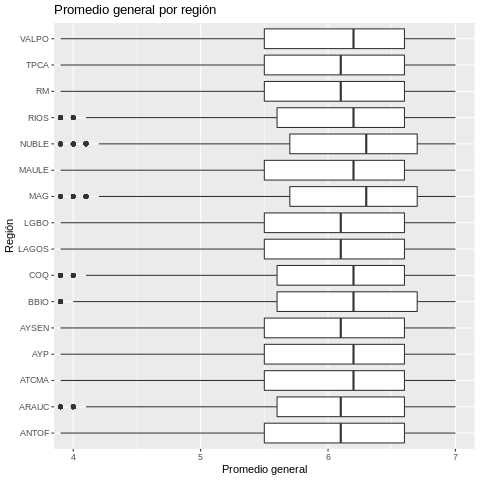

In [24]:
%%R
library(ggplot2)
ggplot(rend2021PromRep, aes(x = NOM_REG_RBD_A, y = PROM_GRAL)) + 
  geom_boxplot() + 
  coord_flip(ylim = c(4,NA)) + 
  ggtitle("Promedio general por región") + # título
  xlab("Región") + ylab("Promedio general")  # etiquetas

Se puede apreciar que son todas muy similares, aunque se evidencian algunas regiones con un rendimiento superior.

Podemos también explorar la distribución de la asistencia en las diferentes regiones.

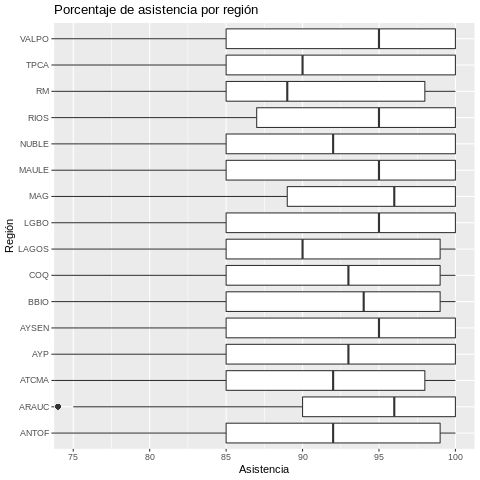

In [25]:
%%R
ggplot(rend2021PromRep, aes(x = NOM_REG_RBD_A, y = ASISTENCIA)) + 
  geom_boxplot() + 
  coord_flip(ylim = c(75,NA)) + 
  ggtitle("Porcentaje de asistencia por región") + # título
  xlab("Región") + ylab("Asistencia")  # etiquetas

Aquí se aprecia mayor variedad en las medias, además de dos regiones (Magallanes y La Araucanía) con Q1 notoriamente mayor.

Otra distribución de promedios que podemos explorar es aquella en relación al índice de ruralidad.

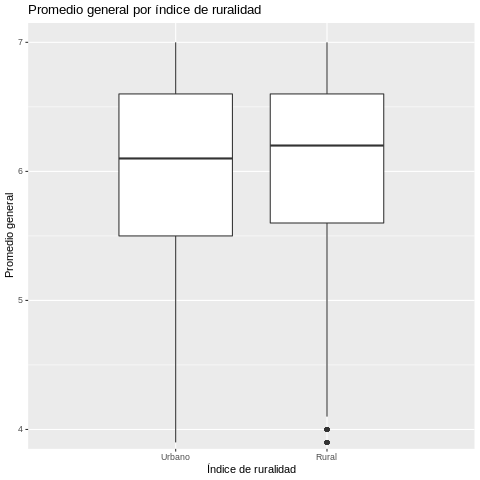

In [26]:
%%R
ggplot(rend2021PromRep, aes(group = RURAL_RBD, x = RURAL_RBD, y = PROM_GRAL)) + 
  geom_boxplot() + 
  coord_cartesian(ylim = c(4,NA)) + 
  scale_x_discrete(limits=c(0,1),labels=c("Urbano", "Rural")) + 
  ggtitle("Promedio general por índice de ruralidad") + # título
  xlab("Índice de ruralidad") + ylab("Promedio general")  # etiquetas

Son muy parecidas.

De manera similar, podemos explorar la relación entre asistencia e índice de ruralidad.

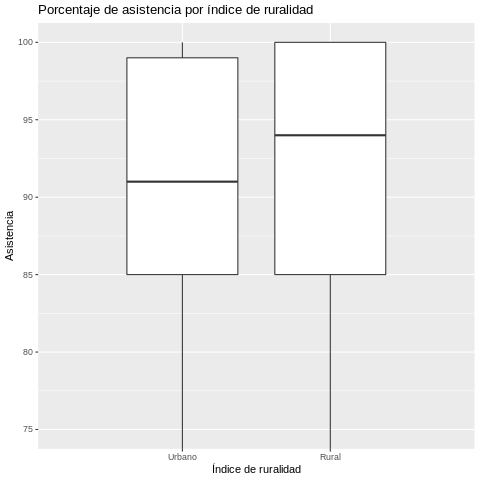

In [27]:
%%R
ggplot(rend2021PromRep, aes(group = RURAL_RBD, x = RURAL_RBD, y = ASISTENCIA)) + 
  geom_boxplot() +  
  coord_cartesian(ylim = c(75,NA)) + 
  scale_x_discrete(limits=c(0,1),labels=c("Urbano", "Rural")) + 
  ggtitle("Porcentaje de asistencia por índice de ruralidad") + # título
  xlab("Índice de ruralidad") + ylab("Asistencia")  # etiquetas

Son muy similares, con una leve ventaja (de un par de puntos porcentuales sobre el promedio) para los alumnos que asisten a establecimientos rurales. 

Como preparación para las etapas posteriores eliminaremos algunos que consideramos redundantes o que no aportan información relevante. En el Anexo A se puede encontrar la descripción de cada atributo.

Además, reemplazamos los valores categóricos de "Promovido" y "Reprobado" por valores numéricos 1 y 0 respectivamente, para poder usar dicho atributo en las etapas siguientes.

En esta etapa se obtiene un dataset con 3091645 datos y 19 atributos.

In [8]:
columnsToDel = ['AGNO','DGV_RBD','NOM_RBD','NOM_REG_RBD_A','NOM_COM_RBD','NOM_DEPROV_RBD','COD_DEPE','ESTADO_ESTAB','COD_ENSE','LET_CUR',
                'COD_DES_CUR','MRUN','FEC_NAC_ALU','NOM_COM_ALU','COD_SEC','COD_ESPE','SIT_FIN','COD_MEN']
rend2021PromRep = rend2021PromRep.drop(columns=columnsToDel)

In [9]:
rend2021PromRep["SIT_FIN_R"].replace({"P": 1, "R": 0}, inplace=True)

In [10]:
rend2021PromRep

RBD  COD_REG_RBD  COD_PRO_RBD  COD_COM_RBD  COD_DEPROV_RBD  \
1            1           15          151        15101             151   
2            1           15          151        15101             151   
3            1           15          151        15101             151   
5            1           15          151        15101             151   
6            1           15          151        15101             151   
...        ...          ...          ...          ...             ...   
3237038  41955            8           83         8301              82   
3237040  41955            8           83         8301              82   
3237041  41955            8           83         8301              82   
3237042  41955            8           83         8301              82   
3237043  41955            8           83         8301              82   

         COD_DEPE2  RURAL_RBD  COD_ENSE2  COD_GRADO  COD_JOR  COD_TIP_CUR  \
1                5          0          8          3        4            0   
2                5          0          8          3        4            0   
3                5          0          8          3        4            0   
5                5          0          8          3        4            0   
6                5          0          8          4        4            0   
...            ...        ...        ...        ...      ...          ...   
3237038          2          0          5          1        1            0   
3237040          2          0          5          2        1            0   
3237041          2          0          5          2        1            0   
3237042          2          0          5          3        1            0   
3237043          2          0          5          3        1            0   

         GEN_ALU  EDAD_ALU  COD_REG_ALU  COD_COM_ALU  COD_RAMA  PROM_GRAL  \
1              2        54           15        15101       400        6.5   
2              2        32           15        15101       400        6.5   
3              2        24           15        15101       400        5.8   
5              2        43            1         1101       400        4.1   
6              1        25           15        15101       400        4.8   
...          ...       ...          ...          ...       ...        ...   
3237038        1        16            8         8301         0        7.0   
3237040        2        15           13        13125         0        6.5   
3237041        2        16            8         8306         0        5.0   
3237042        2        17            8         8301         0        6.6   
3237043        2        16            8         8313         0        6.6   

         ASISTENCIA  SIT_FIN_R  
1                98          1  
2                98          1  
3                90          1  
5                70          0  
6                85          1  
...             ...        ...  
3237038         100          1  
3237040         100          1  
3237041         100          1  
3237042         100          1  
3237043         100          1  

[3091645 rows x 19 columns]

Finalmente se filtrarán los datos de los estudiantes para considerar solo aquellos que se encuentran en educación media, debido al tiempo que consume trabajar con una cantidad tan grande de datos.

In [11]:
rend2021Med = rend2021PromRep[rend2021PromRep.COD_ENSE2 > 4]
rend2021Med

RBD  COD_REG_RBD  COD_PRO_RBD  COD_COM_RBD  COD_DEPROV_RBD  \
1            1           15          151        15101             151   
2            1           15          151        15101             151   
3            1           15          151        15101             151   
5            1           15          151        15101             151   
6            1           15          151        15101             151   
...        ...          ...          ...          ...             ...   
3237038  41955            8           83         8301              82   
3237040  41955            8           83         8301              82   
3237041  41955            8           83         8301              82   
3237042  41955            8           83         8301              82   
3237043  41955            8           83         8301              82   

         COD_DEPE2  RURAL_RBD  COD_ENSE2  COD_GRADO  COD_JOR  COD_TIP_CUR  \
1                5          0          8          3        4            0   
2                5          0          8          3        4            0   
3                5          0          8          3        4            0   
5                5          0          8          3        4            0   
6                5          0          8          4        4            0   
...            ...        ...        ...        ...      ...          ...   
3237038          2          0          5          1        1            0   
3237040          2          0          5          2        1            0   
3237041          2          0          5          2        1            0   
3237042          2          0          5          3        1            0   
3237043          2          0          5          3        1            0   

         GEN_ALU  EDAD_ALU  COD_REG_ALU  COD_COM_ALU  COD_RAMA  PROM_GRAL  \
1              2        54           15        15101       400        6.5   
2              2        32           15        15101       400        6.5   
3              2        24           15        15101       400        5.8   
5              2        43            1         1101       400        4.1   
6              1        25           15        15101       400        4.8   
...          ...       ...          ...          ...       ...        ...   
3237038        1        16            8         8301         0        7.0   
3237040        2        15           13        13125         0        6.5   
3237041        2        16            8         8306         0        5.0   
3237042        2        17            8         8301         0        6.6   
3237043        2        16            8         8313         0        6.6   

         ASISTENCIA  SIT_FIN_R  
1                98          1  
2                98          1  
3                90          1  
5                70          0  
6                85          1  
...             ...        ...  
3237038         100          1  
3237040         100          1  
3237041         100          1  
3237042         100          1  
3237043         100          1  

[1034457 rows x 19 columns]

Finalmente se obtiene un dataset con 1034457 datos y 19 atributos.

## Preguntas y problemas
* Predecir los valores de asistencia de un alumno basado en sus otros atributos.

* Predecir los valores de rendimiento de un alumno basado en sus otros atributos.

* Un análisis visual da ciertos indicios de la existencia de grupos de alumnos según algunas de sus características. ¿Cómo podemos confirmar la existencia de estos grupos, y en base a qué características se conforman?

## Propuesta experimental
* Usaremos técnicas de clustering (K-means y DBSCAN) con distintos números de clusters para encontrar si se conforman grupos de estudiantes de acuerdo a las características presentes en el dataset.
* Para evaluar los resultados de nuestras técnicas de clustering usaremos el enfoque visual y una métrica como el coeficiente de silhouette.
* Usaremos técnicas de clasificación para abordar las preguntas relativas a predicciones sobre el dataset. Para ello, usaremos el dataset y las clases determinadas en clustering para crear modelos de clasificación que permitan estimar el rendimiento y la asistencia de un alumno a partir de sus características.
* Para verificar los resultados de clasificación usaremos distintos algoritmos (KNN, Gaussian Naive Bayes) y métricas (Precision, F1).
* Dada la alta dimensionalidad del dataset, consideramos Gaussian Naive Bayes como una buena opción. La métrica Precision creemos que será de nuestro interés, pues deseamos que nuestras predicciones tengan una alta tasa de éxito.


## Experimento preliminar

Se utilizará K-means para clustering. Se usa la librería Faiss dada su mejor optimización, lo que ayuda en los tiempos de respuesta.

In [28]:
from sklearn.cluster import KMeans
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np

In [29]:
!pip install faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85.5 MB 144 kB/s 


El código siguiente (obtenido de [[1]](https://jovian.ai/aninditaduttachowdhury/session-10)) permite utilizar K-means de Faiss de la misma manera que K-means de scikit.

In [30]:
import faiss # this will import the faiss library
import numpy as np


class FaissKMeans:
    def __init__(self, n_clusters=8, n_init=10, max_iter=300):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.kmeans = None
        self.cluster_centers_ = None
        self.inertia_ = None

    def fit(self, X):
        self.kmeans = faiss.Kmeans(d=X.shape[1],
                                   k=self.n_clusters,
                                   niter=self.max_iter,
                                   nredo=self.n_init)
        self.kmeans.train(X.astype(np.float32))
        self.cluster_centers_ = self.kmeans.centroids
        self.inertia_ = self.kmeans.obj[-1]
    
    def predict(self, X):
       return self.kmeans.index.search(X.astype(np.float32), 1)[1]

Para poder usar el dataframe con Faiss se requiere transformarlo en un arreglo de NumPy. Además, para usarlo con su implementación de K-means se requiere hacer el arreglo contiguo.

In [31]:
rend2021MedNp = np.ascontiguousarray(rend2021Med.to_numpy())

Aplicamos la técnica del codo para determinar las mejores opciones sobre la cantidad de clusters.

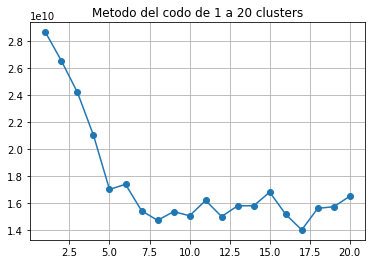

In [32]:
sse = []

clusters = list(range(1, 21))
for k in clusters:
    kmeans = FaissKMeans(n_clusters=k)
    kmeans.fit(rend2021MedNp)
    sse.append(kmeans.inertia_)

plt.plot(clusters, sse, marker="o")
plt.title("Metodo del codo de 1 a 20 clusters")
plt.grid(True)
plt.show()

Obtenemos que 5 clusters parece ser la cantidad adecuada. Para esta cantidad llevamos a cabo K-means

In [33]:
kmeans = FaissKMeans(n_clusters=5)
kmeans.fit(rend2021MedNp)
y_pred = kmeans.predict(rend2021MedNp)
y_pred

array([[1],
       [1],
       [1],
       ...,
       [4],
       [4],
       [4]])

Reducimos dimensionalidad para poder apreciar los resultados gráficamente

In [34]:
from sklearn.decomposition import PCA
rend2021DimRed = PCA(n_components=2, random_state=0).fit_transform(rend2021Med)

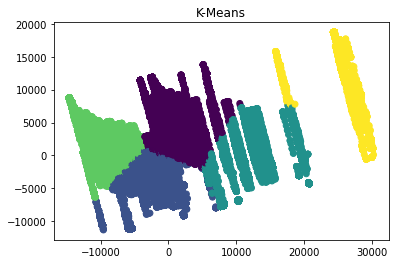

In [35]:
plt.scatter(rend2021DimRed[:, 0], rend2021DimRed[:, 1], c=y_pred)
plt.title("K-Means")
plt.show()

Gráficamente no es posible apreciar que representan los diferentes clusters obtenidos. Debido a esto, no estamos seguros de poder responder a las inquietudes manifestadas.

##Repositorio
https://gitlab.com/scontreras09/cphmr-datos

Los datos fueron obtenidos desde la plataforma de datos abiertos del Centro de Estudios del Ministerio de Educación: https://datosabiertos.mineduc.cl/rendimiento-por-estudiante-2/ (también disponibles en el repositorio anterior).



## Trabajo realizado
 -   Sebastián Contreras: Redacción de la introducción, contribución en redacción de la sección de exploración de datos y preguntas. Limpieza de datos inicial, elaboración de gráficos _boxplot_. Elaboración conjunta de presentación y de secciones exclusivas de Hito 2.

 -   Alejandro Vera: Contribución en redacción de la sección de exploración de datos y preguntas, exploración de datos aplicando medidas de tendencia central, análisis de la relación de los alumnos con los establecimientos(por diferentes categorias). Elaboración conjunta de presentación y de secciones exclusivas de Hito 2.

## Anexo A
Atributos presentes en el dataset final:
* RBD: Rol base de datos del establecimiento.
* COD_REG_RBD: Código de región en que se ubica el establecimiento.
* COD_PRO_RBD: Código oficial de provincia en que se ubica el establecimiento.
* COD_COM_RBD: Código oficial comuna en que se ubica el establecimiento.
* NOM_COM_RBD: Nombre de la comuna en que se ubica el establecimiento
* COD_DEPROV_RBD: Código del Departamento Provincial de Educación al que pertenece el establecimiento
* COD_DEPE2: Código de Dependencia del Establecimiento (agrupado).
* RURAL_RBD: Índice de ruralidad del establecimiento.
* COD_ENSE2: Niveles de enseñanza agrupados.
* COD_GRADO: Código de grado.
* COD_JOR: Jornada en la que asiste a clases.
* COD_TIP_CUR:    Índice de tipo de curso.
* GEN_ALU: Género del estudiante.
* EDAD_ALU: Edad al 30 de junio del correspondiente año escolar.
* COD_REG_ALU: Código de la región de residencia del estudiante.
* COD_COM_ALU:  Código oficial comuna de residencia (auto declarado y voluntario).
* COD_RAMA: Código de rama (sólo media técnico profesional y artística).
* PROM_GRAL: Promedio general anual.
* ASISTENCIA: Porcentaje anual de asistencia
* SIT_FIN_R: Situación de promoción al cierre del año escolar, con indicador de traslado.

Atributos eliminados del dataset original:
* AGNO: Año escolar.
* DGV_RBD: Dígito Verificador del RBD.
* NOM_RBD: Nombre del Establecimiento.
* NOM_REG_RBD_A: Nombre abreviado de la región en que se ubica el establecimiento.
* NOM_COM_RBD: Nombre de la comuna en que se ubica el establecimiento.
* NOM_DEPROV_RBD: Nombre del Departamento Provincial de Educación al que pertenece el establecimiento.
* COD_DEPE: Código de Dependencia del Establecimiento.
* ESTADO_ESTAB: Estado del establecimiento.
* COD_ENSE: Código de enseñanza.
* LET_CUR: Letra del curso.
* COD_DES_CUR: Descripción del curso (solo aplica para enseñanza media TP).
* MRUN: Corresponde a la máscara del RUN del alumno.
* FEC_NAC_ALU: Fecha de nacimiento del estudiante (AAAAMM).
* NOM_COM_ALU: Nombre de la comuna de residencia.
* COD_SEC: Código de sector económico (sólo media técnico-profesional y artística).
* COD_ESPE: Código de especialidad (sólo media técnico-profesional y artística).
* SIT_FIN: Situación de promoción al cierre del año escolar.
* COD_MEN: Mención.